In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torchvision.transforms as T
import timm

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# Custom Dataset

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dir, classes, transforms):
        super().__init__()
        self.data = []
        self.dir = dir
        self.transforms = transforms

        for i, cls in enumerate(classes):
            cls_path = os.path.join(dir, cls)
            img_list = os.listdir(cls_path)
            for img in img_list:
                if img != '.DS_Store':
                    self.data.append((os.path.join(cls_path, img),i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]
        
        return img, label

In [4]:
classes = ['crack', 'normal']
transforms = T.Compose([
    T.Resize((112, 112)),
    T.ToTensor()
])

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/3/data/train', classes, transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/3/data/val', classes, transforms)
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/3/data/test', classes, transforms)

In [5]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

35550 3300 200


In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# train, eval

In [7]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_accuracy = 0
    train_loss = 0.0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}')

    valid_accuracy /= len(valid_dataset)
    valid_loss /= len(valid_dataloader)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

# model

In [8]:
model = timm.create_model(
    'resnet18',
    pretrained=True,
    num_classes=len(classes)
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [9]:
for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.fc.parameters():
    parameter.requires_grad = True

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.1679994769112991, Train Accuracy: 0.9582841068917018, Valid Loss: 0.07919109326142532, Valid Accuracy: 0.9803030303030303


  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.07628498779167589, Train Accuracy: 0.9783403656821378, Valid Loss: 0.054916880738276705, Valid Accuracy: 0.9851515151515151


  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.06147710841463999, Train Accuracy: 0.9812095639943741, Valid Loss: 0.04879257559346465, Valid Accuracy: 0.9848484848484849


  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.05572166261028686, Train Accuracy: 0.9822222222222222, Valid Loss: 0.04319562936703173, Valid Accuracy: 0.9878787878787879


  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.048597106406893985, Train Accuracy: 0.9845569620253165, Valid Loss: 0.04158836671222861, Valid Accuracy: 0.9872727272727273


  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.048854449499237666, Train Accuracy: 0.9833473980309423, Valid Loss: 0.038359064635677405, Valid Accuracy: 0.9884848484848485


  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.04481465994420616, Train Accuracy: 0.9851195499296765, Valid Loss: 0.03770728337650116, Valid Accuracy: 0.9881818181818182


  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.044248433392528416, Train Accuracy: 0.9845850914205344, Valid Loss: 0.037224642610034116, Valid Accuracy: 0.9875757575757576


  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.04171063372004349, Train Accuracy: 0.9858227848101265, Valid Loss: 0.036147985562610514, Valid Accuracy: 0.9893939393939394


  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Train Loss: 0.04084683880553306, Train Accuracy: 0.9861322081575246, Valid Loss: 0.034308724015807875, Valid Accuracy: 0.9896969696969697


# test

In [16]:
model.eval()
total_preds = []
total_labels = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs)
        loss = criterion(outputs, labels)

        max_prob, preds = torch.max(probs, 1)
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

  0%|          | 0/4 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_65731/574039400.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(outputs)


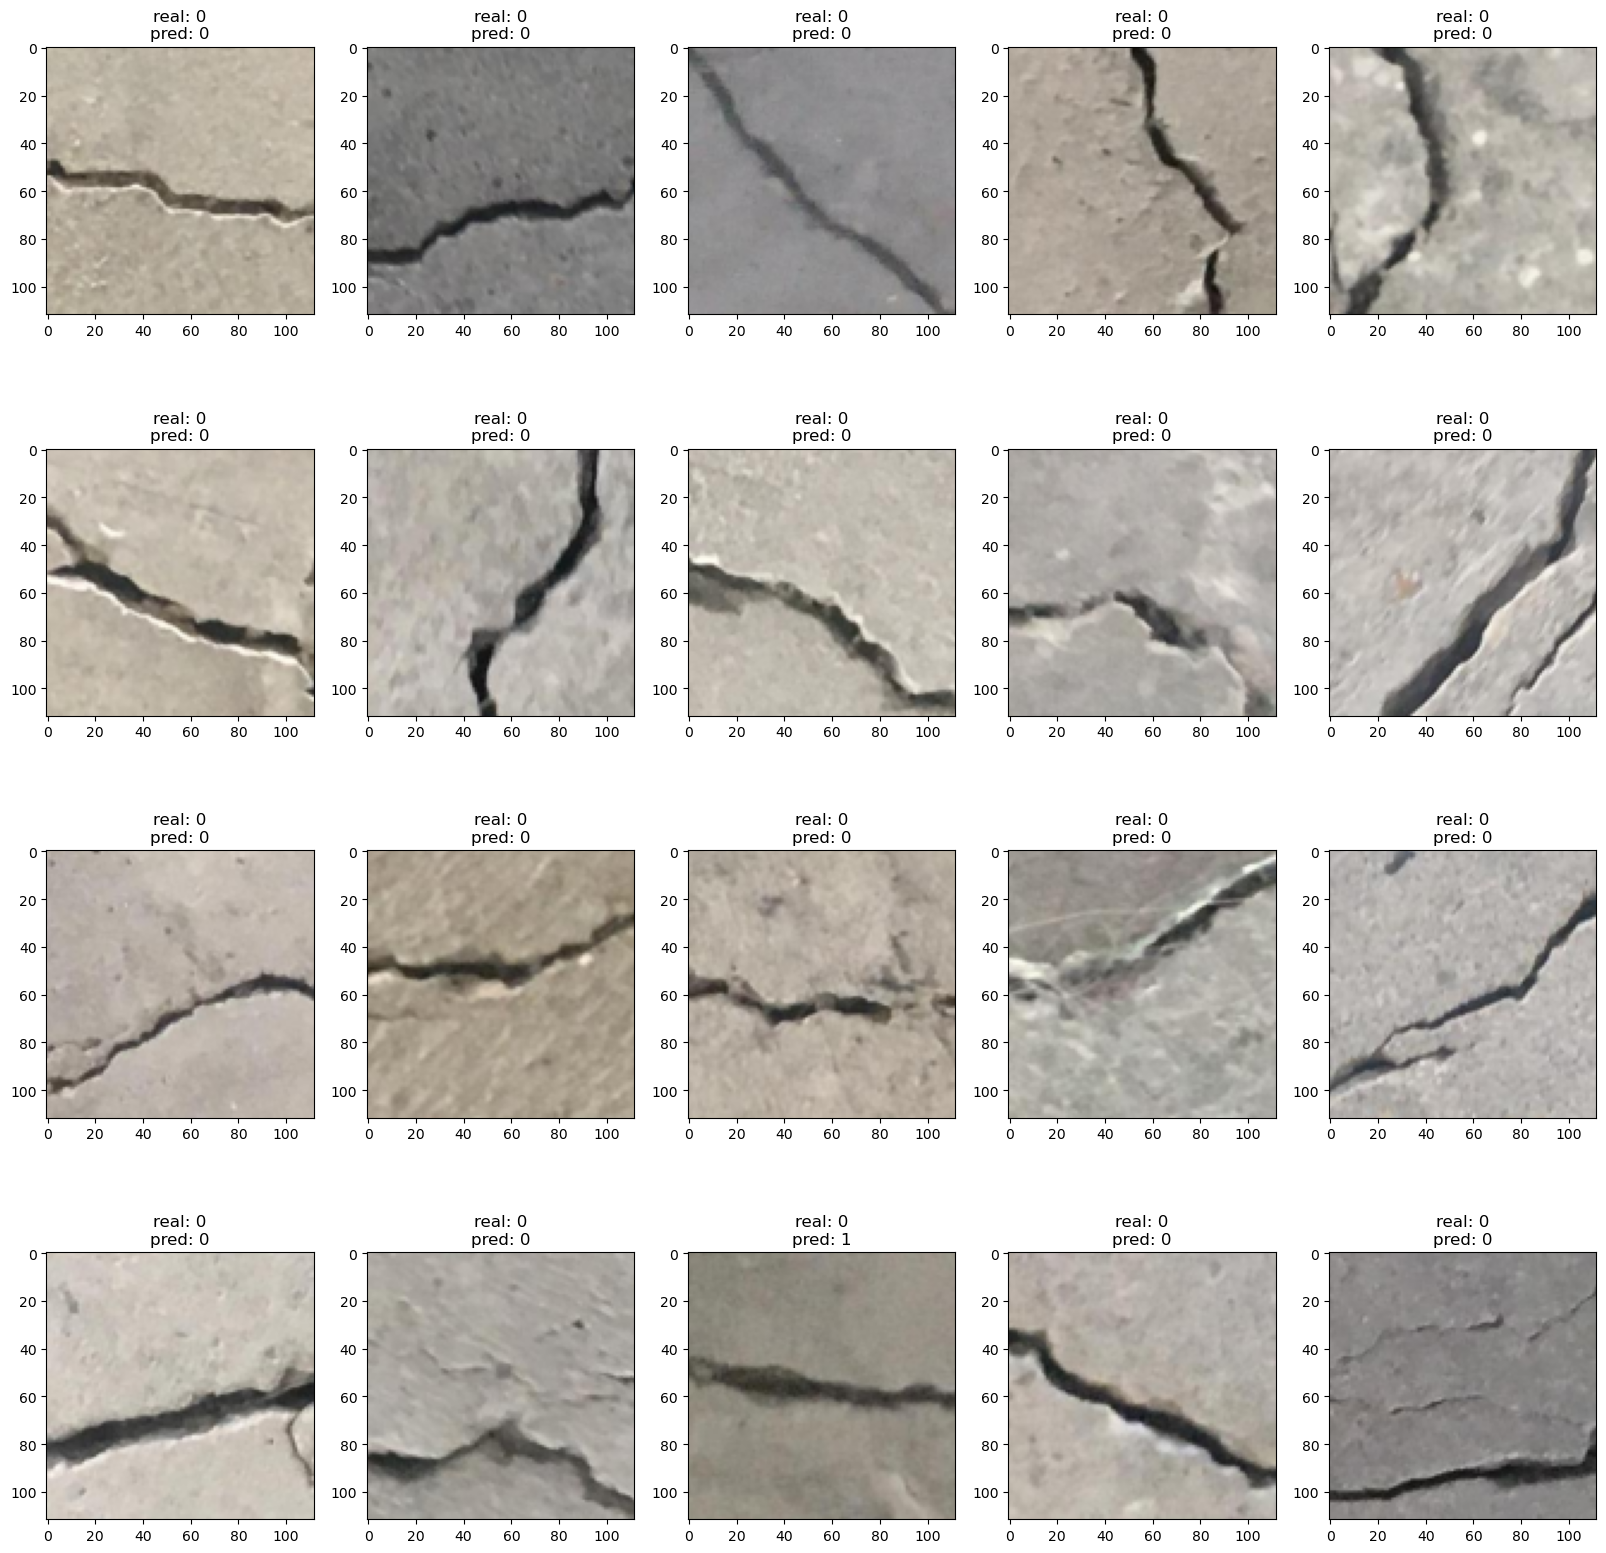

In [17]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    label = test_dataset[i][1]
    pred = total_preds[i]

    plt.title(f'real: {label}\npred: {pred}')

In [19]:
from sklearn.metrics import f1_score

f1_score(total_labels, total_preds, average='macro')

0.9849996249906248